In [1]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
import random
from tqdm.auto import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam

import albumentations as A
AUTOTUNE = tf.data.experimental.AUTOTUNE

2022-05-09 14:35:42.444529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


- [Data augmentation Tensorflow Docs](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko)
- [EfficientNetb3 Docs](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB3)
- [blog](https://hwiyong.tistory.com/397)
- [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- [Albumentations Docs for segmentation](https://albumentations.ai/docs/getting_started/mask_augmentation/)
- [tensorlfow data pipeline bulid](https://www.tensorflow.org/guide/data?hl=ko)

# Data Load

In [2]:
def get_data(data_dir):
    # get image path
    img_path = os.listdir(data_dir)
    try :
        img_path.remove('.ipynb_checkpoints')
    except:
        pass
    img_path_list = [os.path.join(data_dir, x) for x in img_path]
    img_path_list = sorted(img_path_list)
    return img_path_list  # img 들의 경로를 리스트로 리턴

In [3]:
##### 경로 설정 ######

DATA_DIR = './data/segmentation'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'validannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')


### data dir  
#x_train_img = tf.data.TextLineDataset(get_data(x_train_dir))
#y_train_img = tf.data.TextLineDataset(get_data(y_train_dir))
x_train_img_dir = get_data(x_train_dir)
y_train_img_dir = get_data(y_train_dir)

x_valid_img_dir = get_data(x_valid_dir)
y_valid_img_dir = get_data(y_valid_dir)

In [4]:
def load_img(img_dir, mask_dir, target_size) :
    img = tf.io.read_file(img_dir)
    if img_dir[-3:] == 'png':
        img = tf.io.decode_png(img, channels=3)
    elif img_dir[-3:] == 'jpg':
        img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, target_size)
    
    mask = tf.io.read_file(mask_dir)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.image.resize(mask, target_size)
    return img, mask

In [5]:
def load_img_numpy(img_dir, mask_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    
    mask = cv2.imread(mask_dir)
    mask = cv2.resize(mask, dsize=target_size)
    mask = mask[..., :1]
    mask = mask.astype(np.float32)
    
    return img, mask

In [7]:
x_train_img = [] # 원본이미지
y_train_img = [] # 마스크 이미지

for i, m in zip(x_train_img_dir, y_train_img_dir):
    img, mask = load_img_numpy(i, m, (128,128))
    x_train_img.append(img)
    y_train_img.append(mask)
    
    
x_valid_img = []
y_valid_img = []

for i, m in zip(x_valid_img_dir, y_valid_img_dir):
    img, mask = load_img_numpy(i, m, (128,128))
    x_valid_img.append(img)
    y_valid_img.append(mask)

In [6]:
x_train_img = [] # 원본이미지
y_train_img = [] # 마스크 이미지

for i, m in zip(x_train_img_dir, y_train_img_dir):
    img, mask = load_img(i, m, (128,128))
    x_train_img.append(img)
    y_train_img.append(mask)

2022-05-04 10:46:57.424023: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 10:46:57.427179: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 10:46:57.429306: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
x_valid_img = []
y_valid_img = []

for i, m in zip(x_valid_img_dir, y_valid_img_dir):
    img, mask = load_img(i, m, (128,128))
    x_valid_img.append(img)
    y_valid_img.append(mask)

### 불러온 이미지 확인

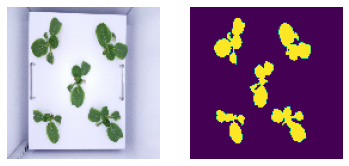

In [7]:
img, mask = x_train_img[1], y_train_img[1]
test = [img, mask[..., 0]]
fig = plt.figure()
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.imshow(test[i]) #plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    ax.axis('off')
plt.show()

In [8]:
print(type(img))
print(type(mask))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [9]:
print(img.shape)
print(mask.shape)

(128, 128, 3)
(128, 128, 1)


In [11]:
np.unique(mask.numpy())

array([0.        , 0.00015319, 0.0002451 , 0.00045956, 0.00045956,
       0.00073529, 0.00082721, 0.00101103, 0.00119485, 0.00168505,
       0.00171569, 0.00199142, 0.00220588, 0.00235907, 0.00245098,
       0.00254289, 0.00269608, 0.00278799, 0.00309436, 0.00315564,
       0.00318627, 0.00327819, 0.00343137, 0.00364583, 0.00367647,
       0.00370711, 0.00376838, 0.00389093, 0.00392157], dtype=float32)

# Dataset으로 만들기

In [8]:
TRAIN_LENGTH = 160
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
# train
x = Dataset.from_tensor_slices(x_train_img)
y = Dataset.from_tensor_slices(y_train_img)
train_dataset = Dataset.zip((x, y))

2022-05-04 11:12:21.757518: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 11:12:21.759647: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 11:12:21.761664: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
# valid
x = Dataset.from_tensor_slices(x_valid_img)
y = Dataset.from_tensor_slices(y_valid_img)
valid_dataset = Dataset.zip((x, y))

In [11]:
train_dataset2 = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset2 = train_dataset2.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
valid_dataset2 = valid_dataset.batch(BATCH_SIZE)

# Model from tensorflow tutorial

In [13]:
OUTPUT_CHANNELS = 2

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [15]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 건너뛰기 연결을 업샘플링하고 설정하세요
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),#from_logits=True
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

In [19]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 50//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset2, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=valid_dataset2)

Epoch 1/20


2022-05-04 11:12:35.554521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-04 11:12:35.588897: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


2/2 [==============================] - 11s 4s/step - loss: 3.3366 - accuracy: 0.6126
Epoch 2/20
2/2 [==============================] - 5s 2s/step - loss: 2.7092 - accuracy: 0.5454
Epoch 3/20
2/2 [==============================] - 6s 3s/step - loss: 1.9673 - accuracy: 0.5264
Epoch 4/20
2/2 [==============================] - 5s 2s/step - loss: 1.6124 - accuracy: 0.4479
Epoch 5/20
2/2 [==============================] - 6s 3s/step - loss: 1.5349 - accuracy: 0.4298
Epoch 6/20
2/2 [==============================] - 5s 2s/step - loss: 1.3737 - accuracy: 0.4729
Epoch 7/20
2/2 [==============================] - 6s 3s/step - loss: 1.4391 - accuracy: 0.4803
Epoch 8/20
2/2 [==============================] - 5s 2s/step - loss: 1.2345 - accuracy: 0.4847
Epoch 9/20
2/2 [==============================] - 6s 3s/step - loss: 1.2285 - accuracy: 0.4971
Epoch 10/20
2/2 [==============================] - 5s 2s/step - loss: 1.1264 - accuracy: 0.5013
Epoch 11/20
2/2 [==============================] - 6s 3s/st

# Prediction

In [20]:
# load image
test = './data/test/image/001.png'

def load_test_img(img_dir):
    img = tf.io.read_file(img_dir)
    if img_dir[-3:] == 'png':
        img = tf.io.decode_png(img, channels=3)
    elif img_dir[-3:] == 'jpg':
        img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [128,128])
    return img

test = load_test_img(test)

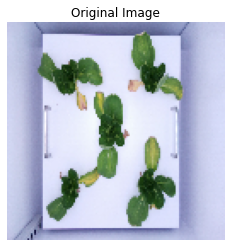

In [21]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(test))
plt.title('Original Image')
plt.axis('off')
plt.show()

In [22]:
test.shape

TensorShape([128, 128, 3])

In [23]:
test_dataset = Dataset.from_tensor_slices([[test]])
pred = model.predict(test_dataset)

In [24]:
type(pred)

numpy.ndarray

In [25]:
pred[0].shape

(128, 128, 2)

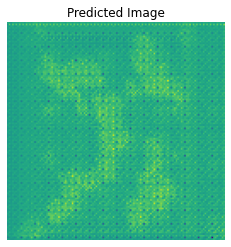

In [26]:
plt.imshow(pred[0][..., :1])
plt.title('Predicted Image')
plt.axis('off')
plt.show()

---
AUGMENTATION 추가

In [6]:
# heavy augmentation
original_height, original_width = 128, 128
aug = A.Compose([
    A.Resize(128, 128), 
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
        A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
    ], p=1),    
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)])

random.seed(11)

In [54]:
aug_x_train = []
aug_y_train = []

for i, m in zip(x_train_img_dir, y_train_img_dir):
    img = cv2.imread(i)
    mask = cv2.imread(m)
    augmentation = aug(image= img, mask=mask)
    aug_x_train.append(augmentation['image']/255.)
    aug_y_train.append(augmentation['mask']/255.)

In [1]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(tf.keras.preprocessing.image.array_to_img(mask))
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

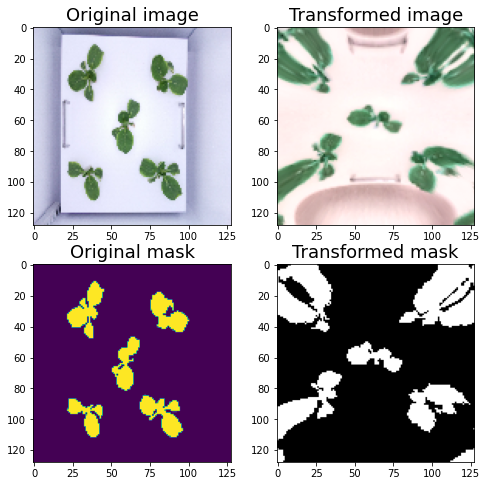

In [56]:
visualize(aug_x_train[0], aug_y_train[0], x_train_img[0], y_train_img[0])

In [57]:
x = Dataset.from_tensor_slices(aug_x_train)
y = Dataset.from_tensor_slices(aug_y_train)
aug_train_dataset = Dataset.zip((x, y))
aug_train_dataset = aug_train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
aug_train_dataset = aug_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [60]:
model2 = unet_model(OUTPUT_CHANNELS)
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),#from_logits=True
              metrics=['accuracy'])

EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 50//BATCH_SIZE//VAL_SUBSPLITS

model2_history = model2.fit(train_dataset2, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=valid_dataset2)

Epoch 1/10
2/2 [==============================] - 10s 3s/step - loss: 1.4041 - accuracy: 0.2977
Epoch 2/10
2/2 [==============================] - 5s 2s/step - loss: 0.1526 - accuracy: 0.3107
Epoch 3/10
2/2 [==============================] - 6s 3s/step - loss: 0.0179 - accuracy: 0.3005
Epoch 4/10
2/2 [==============================] - 5s 2s/step - loss: 0.0123 - accuracy: 0.3030
Epoch 5/10
2/2 [==============================] - 6s 3s/step - loss: 0.0124 - accuracy: 0.2947
Epoch 6/10
2/2 [==============================] - 5s 2s/step - loss: 0.0124 - accuracy: 0.2917
Epoch 7/10
2/2 [==============================] - 6s 3s/step - loss: 0.0126 - accuracy: 0.2864
Epoch 8/10
2/2 [==============================] - 5s 2s/step - loss: 0.0126 - accuracy: 0.2850
Epoch 9/10
2/2 [==============================] - 6s 3s/step - loss: 0.0127 - accuracy: 0.2819
Epoch 10/10
2/2 [==============================] - 5s 2s/step - loss: 0.0128 - accuracy: 0.2790


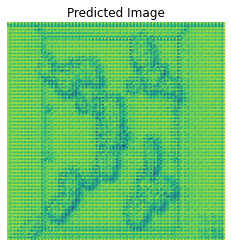

In [63]:
pred = model2.predict(test_dataset)

plt.imshow(tf.keras.preprocessing.image.array_to_img(pred[0][...,:1]))
plt.title('Predicted Image')
plt.axis('off')
plt.show()

# 다른 U-Net 
- https://idiotdeveloper.com/unet-implementation-in-tensorflow-using-keras-api/

In [6]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [8]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [9]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [11]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.summary()

2022-05-04 11:17:59.527493: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 11:17:59.527784: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 11:17:59.528046: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',#from_logits=True
              metrics=['accuracy'])

In [14]:
x_train_img = [] # 원본이미지
y_train_img = [] # 마스크 이미지

for i, m in zip(x_train_img_dir, y_train_img_dir):
    img, mask = load_img_numpy(i, m, (256,256))
    x_train_img.append(img)
    y_train_img.append(mask)

In [15]:
x_valid_img = []
y_valid_img = []

for i, m in zip(x_valid_img_dir, y_valid_img_dir):
    img, mask = load_img(i, m, (256,256))
    x_valid_img.append(img)
    y_valid_img.append(mask)

In [16]:
BATCH_SIZE = 4

# train
x = Dataset.from_tensor_slices(x_train_img)
y = Dataset.from_tensor_slices(y_train_img)
train_dataset = Dataset.zip((x, y))

# valid
x = Dataset.from_tensor_slices(x_valid_img)
y = Dataset.from_tensor_slices(y_valid_img)
valid_dataset = Dataset.zip((x, y))

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
#train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
EPOCHS = 10
STEPS_PER_EPOCH = len(x_train_img) // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/10
57/57 [==============================] - 534s 9s/step - loss: 0.1389 - accuracy: 0.9773
Epoch 2/10
57/57 [==============================] - 534s 9s/step - loss: 0.1067 - accuracy: 0.9828
Epoch 3/10
57/57 [==============================] - 537s 9s/step - loss: 0.0922 - accuracy: 0.9839
Epoch 4/10
57/57 [==============================] - 474s 8s/step - loss: 0.0841 - accuracy: 0.9846
Epoch 5/10
57/57 [==============================] - 432s 8s/step - loss: 0.0777 - accuracy: 0.9851
Epoch 6/10
57/57 [==============================] - 434s 8s/step - loss: 0.0734 - accuracy: 0.9853
Epoch 7/10
57/57 [==============================] - 430s 8s/step - loss: 0.0694 - accuracy: 0.9855
Epoch 8/10
57/57 [==============================] - 430s 8s/step - loss: 0.0671 - accuracy: 0.9857
Epoch 9/10
57/57 [==============================] - 430s 8s/step - loss: 0.0648 - accuracy: 0.9858
Epoch 10/10
57/57 [==============================] - 432s 8s/step - loss: 0.0623 - accuracy: 0.9860


In [19]:
model.save('./Model_Save/segmentation_model_0504.h5')

In [21]:
test = './data/test/image/001.png'

def load_test_img(img_dir, target_size):
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

test = load_test_img(test, (256,256))

In [25]:
test_dataset = Dataset.from_tensor_slices([[test]])
pred = model.predict(test_dataset)

In [26]:
pred[0].shape

(256, 256, 1)

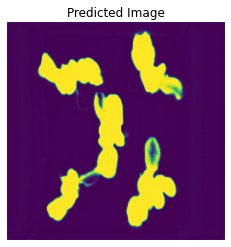

In [27]:
plt.imshow(pred[0])
plt.title('Predicted Image')
plt.axis('off')
plt.show()

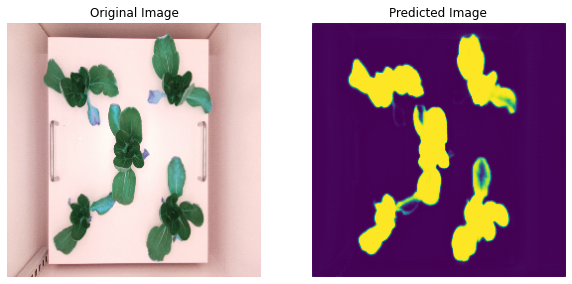

In [33]:
check = [test, pred[0]]
t = ['Original Image', 'Predicted Image']
fig = plt.figure(figsize=(10,5))
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.imshow(check[i])
    ax.set_title(t[i])
    ax.axis('off')
plt.show()

In [34]:
type(pred[0])

numpy.ndarray

In [35]:
type(pred)

numpy.ndarray

In [48]:
x_valid_dir

'./data/segmentation/valid'

In [49]:
valid_imgs = []
for i in get_data(x_valid_dir) :
    valid_imgs.append(load_test_img(i, (256,256)))

In [51]:
dataset = Dataset.from_tensor_slices([valid_imgs])

In [ ]:
predictions = model.predict(dataset)

In [42]:
from tensorflow.keras.metrics import Accuracy, MeanIoU

In [ ]:
acc = Accuracy()
acc.update_state()

In [3]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _MklMatMul in device /job:localhost/replica:0/task:0/device:CPU:0


2022-05-09 10:59:25.775516: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-09 10:59:25.775913: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [5]:
tf.test.is_gpu_available()

[]

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13675489516277616009
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15466496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2031018514097150533
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
]


2022-05-09 15:03:24.917462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 15:03:24.917848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-09 15:03:24.917901: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-09 15:03:24.917952: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-09 15:03:24.917968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-05-09 15:03:24.917982: I tensorflow/stream_executor/platform/defa

In [4]:
tf.config.list_physical_devices('GPU')

2022-05-04 17:31:35.089311: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


[]

# Test dataset

In [8]:
from tensorflow.keras.models import load_model
model = load_model('./Model_Save/segmentation_epoch3.h5')

2022-05-09 15:02:53.274788: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.0KiB (rounded to 589824)requested by op Mul
Current allocation summary follows.
2022-05-09 15:02:53.274840: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2022-05-09 15:02:53.274851: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 48, Chunks in use: 48. 12.0KiB allocated for chunks. 12.0KiB in use in bin. 7.6KiB client-requested in use in bin.
2022-05-09 15:02:53.274858: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 12.8KiB allocated for chunks. 12.8KiB in use in bin. 12.5KiB client-requested in use in bin.
2022-05-09 15:02:53.274864: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 12, Chunks in use: 11. 12.8KiB allocated for chunks. 11.8KiB in use in bin. 11.0KiB client-requested

MaxAllocSize:                  4718592
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-05-09 15:02:53.275767: W tensorflow/core/common_runtime/bfc_allocator.cc:441] *_*******************_*************************************************************************xxxxx
2022-05-09 15:02:53.275790: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at cwise_ops_common.h:128 : Resource exhausted: OOM when allocating tensor with shape[3,3,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]